In [28]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import keras_cv
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# YOLOv8 모델 구성
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling=True)

YOLOV8_model = keras_cv.models.YOLOV8Detector(
    num_classes=1,
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=5
)
YOLOV8_model.load_weights('./yolo_acne_detection.weights.h5')
YOLOV8_model.build(input_shape=(None, 640, 640, 3))

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

part_indices = {
    '이마': [8, 9, 10, 107, 66, 105, 63, 70, 71, 109, 108, 151, 296, 334, 293, 300, 299,
          383, 368, 389, 356, 337, 276, 283, 282, 295, 285, 336]
          + list(range(65, 69)) + list(range(155, 164)),

    '코': [0, 1, 2, 5, 6, 45, 275, 274, 273, 272, 271, 164, 165, 97, 98, 99, 
          2, 94, 95, 96, 240, 218, 219, 220, 237, 218, 134, 399, 398],

    '왼쪽볼': [116, 117, 118, 119, 120, 121, 128, 129, 130, 131, 132,
          226, 113, 225, 224, 223, 222, 221, 189, 190, 137, 138, 139],

    '오른쪽볼': [345, 346, 347, 348, 349, 350, 357, 358, 359, 360, 361,
          447, 366, 440, 439, 438, 437, 436, 435, 414, 413, 412, 364]
          + list(range(380, 390)),

    '턱': [0, 17, 170, 175, 364, 335, 172, 152, 395, 396, 397, 400, 
          61, 146, 91, 181, 84, 17, 314, 402, 13, 14, 15, 86, 178, 87]
}

def get_part_bounding_box(image, landmarks, indices):
    points = np.array([
        [int(landmarks.landmark[i].x * image.shape[1]),
         int(landmarks.landmark[i].y * image.shape[0])]
        for i in indices
    ])
    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)
    return x_min, y_min, x_max, y_max

def crop_and_resize(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    cropped = image[y_min:y_max, x_min:x_max]
    resized = cv2.resize(cropped, (640, 640))
    return resized, (x_min, y_min, x_max, y_max), cropped.shape[:2]

def load_test_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_yolo_predictions(model, img):
    img_tensor = tf.expand_dims(tf.cast(img, tf.float32), axis=0)
    y_pred = model.predict(img_tensor, verbose=0)
    boxes, classes = y_pred["boxes"], y_pred["classes"]
    return [box for box, cls in zip(boxes[0], classes[0]) if cls == 0]

def resize_boxes_to_original(boxes, cropped_size, orig_bbox):
    crop_h, crop_w = cropped_size
    x_min, y_min, _, _ = orig_bbox
    scale_x, scale_y = crop_w / 640, crop_h / 640

    resized_boxes = []
    for x1, y1, x2, y2 in boxes:
        resized_boxes.append([
            x_min + x1 * scale_x,
            y_min + y1 * scale_y,
            x_min + x2 * scale_x,
            y_min + y2 * scale_y
        ])
    return resized_boxes

def analyze_acne_by_parts_result(image_path):
    img = load_test_image(image_path)

    results = face_mesh.process(img)
    if not results.multi_face_landmarks:
        print("얼굴 인식 실패")
        return img, None,None

    face_landmarks = results.multi_face_landmarks[0]
    part_acne_map = {part: False for part in part_indices.keys()}
    acne_boxes_by_part = {part: [] for part in part_indices.keys()}

    for part, indices in part_indices.items():
        bbox = get_part_bounding_box(img, face_landmarks, indices)
        resized_img, orig_bbox, cropped_size = crop_and_resize(img, bbox)

        acne_boxes = get_yolo_predictions(YOLOV8_model, resized_img)
        acne_boxes = resize_boxes_to_original(acne_boxes, cropped_size, orig_bbox)

        if acne_boxes:
            part_acne_map[part] = True
            acne_boxes_by_part[part] = acne_boxes

    print("\n 부위별 여드름 존재 여부")
    for part, has_acne in part_acne_map.items():
        print(f"  {part}: {'있음' if has_acne else '없음'}")

    affected_parts = [part for part, has_acne in part_acne_map.items() if has_acne]
    if affected_parts:
        print(f"\n 여드름 있는 부위: {', '.join(affected_parts)}")
    else:
        print("\n 여드름 없음")
    
    return img, face_landmarks, part_acne_map, acne_boxes_by_part

# 테스트 실행
image_path = './test_F.jpg'
img, face_landmarks, part_acne_map, acne_boxes_by_part = analyze_acne_by_parts_result(image_path)



c:\acne\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2154']
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)



 부위별 여드름 존재 여부
  이마: 있음
  코: 있음
  왼쪽볼: 없음
  오른쪽볼: 없음
  턱: 있음

 여드름 있는 부위: 이마, 코, 턱


In [20]:
import matplotlib.pyplot as plt

def visualize_detected_parts_with_boxes(original_image, face_landmarks, part_indices, detected_parts, acne_boxes_by_part):
    """
    탐지된 부위만 잘라서 여드름 박스와 함께 시각화하는 함수
    - original_image: 원본 얼굴 이미지
    - face_landmarks: Mediapipe에서 검출한 얼굴 랜드마크 정보
    - part_indices: 각 부위별 랜드마크 인덱스
    - detected_parts: 여드름 있는 부위 여부 맵
    - acne_boxes_by_part: 부위별 여드름 박스 좌표들
    """
    for part, indices in part_indices.items():
        if not detected_parts.get(part, False):
            continue  # 여드름 없는 부위는 스킵

        bbox = get_part_bounding_box(original_image, face_landmarks, indices)
        x_min, y_min, x_max, y_max = bbox

        cropped_part = original_image[y_min:y_max, x_min:x_max].copy()

        # 여드름 박스 그리기 (잘린 영역 기준 좌표로 변환해서 그림)
        for box in acne_boxes_by_part.get(part, []):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(cropped_part, (x1 - x_min, y1 - y_min), (x2 - x_min, y2 - y_min), (255, 0, 0), 2)

        plt.figure(figsize=(4, 4))
        plt.imshow(cropped_part)
        plt.title(f"{part} 에 뾰루지!!!!!!")
        plt.axis('off')
        plt.show()


In [16]:
plt.rc('font', family='NanumGothic') 

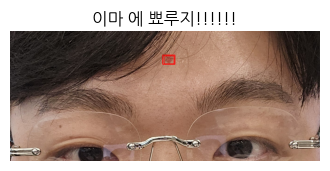

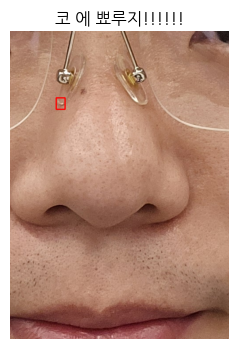

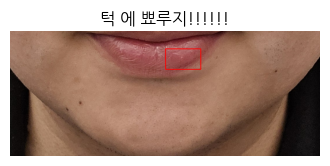

In [29]:
visualize_detected_parts_with_boxes(img, face_landmarks, part_indices, part_acne_map, acne_boxes_by_part)